In [1]:
import numpy as np 
import scipy as sp
import healpy as hp
import matplotlib.pyplot as plt
import mylib
import camb
import pymaster as nmt
from tqdm import tqdm
import obs_cov

In [2]:
nside = 128
lmax = 3*nside - 1
npix = 12 * nside**2

input_cls_lcdm = mylib.get_camb(Alens=1, r=0, lmax=lmax)

input_cls_noBB = np.copy(input_cls_lcdm)
input_cls_noBB[2] = np.zeros(lmax+1)

input_cls_noEE = np.copy(input_cls_lcdm)
input_cls_noEE[1] = np.zeros(lmax+1)
input_cls_noEE[3] = np.zeros(lmax+1)

In [3]:
mask, weight = mylib.get_weight(nside)
fsky = np.sum(mask)/npix
print(fsky*100)

apo_size = 10
mask_apo = nmt.mask_apodization(weight, apo_size, 'C2')

w2 = np.sum(mask_apo**2)/np.sum(mask)
w4 = np.sum(mask_apo**4)/np.sum(mask)

R_unapo = sp.sparse.load_npz(f'obsmat_nside{nside}/obsmat.npz')

Z = sp.sparse.diags_array(mask_apo)
ZZ = sp.sparse.block_diag([Z, Z, Z])
R = ZZ @ R_unapo

pi_b = sp.sparse.load_npz(f'apo{apo_size}/pi_b_6844.npz')

4.40673828125


In [4]:
bin_size = 16
b = nmt.NmtBin.from_nside_linear(nside, bin_size)
ells = b.get_effective_ells()
c2db = ells * (ells+1) /2/np.pi
sigmab = hp.nside2resol(nside)
fwhm = (8*np.log(2))**0.5 * sigmab
bl = hp.gauss_beam(fwhm, lmax)
l = np.arange(lmax+1)
c2d = l * (l+1) / 2/np.pi

In [5]:
planck_T_noise_props = [25, 50, -1.8]
planck_P_noise_props = [50, 20, -1.4]
planck_T = mylib.get_Nl(planck_T_noise_props, lmax)
planck_P = mylib.get_Nl(planck_P_noise_props, lmax)
planck_noise_cls = np.array([planck_T, planck_P, planck_P, np.zeros(lmax+1)])

lb_T_noise_props = [1.8, 2, -1] 
lb_P_noise_props = [2.16, 2, -1] 
lb_T = mylib.get_Nl(lb_T_noise_props, lmax)
lb_P = mylib.get_Nl(lb_P_noise_props, lmax)
lb_noise_cls = np.array([lb_T, lb_P, lb_P, np.zeros(lmax+1)])

/scratch/yuyang/filterbin/mylib.py:110: RuntimeWarning: divide by zero encountered in power
  Nl = n * (l/knee)**alpha + n
/scratch/yuyang/filterbin/mylib.py:110: RuntimeWarning: divide by zero encountered in reciprocal
  Nl = n * (l/knee)**alpha + n


In [6]:
lensingten = mylib.get_camb(1e-1, 0, lmax) #from cmbs4 science book
lensingone = mylib.get_camb(1e-2, 0, lmax)
so = mylib.get_Nl([np.sqrt(2)*2.1, 50, -3], lmax)
s4 = mylib.get_Nl([1, 50, -3], lmax)

In [7]:
pcl = np.load(f'apo{apo_size}/pcl.npy')
pcl_KS = np.load(f'apo{apo_size}/pcl_KS.npy')
pcl_pure = np.load(f'apo{apo_size}/pcl_pure.npy')

mll_KS = mylib.get_mll(mask_apo, nside, b, pol=True, purify_b=True)[2::4,2::4]
mll = mylib.get_mll(mask_apo, nside, b, pol=True)[2::4,2::4]

fl = mylib.get_fl(pcl, bl, mll, input_cls_lcdm[2], fsky*w2, niter=3)
fl_KS = mylib.get_fl(pcl_KS, bl, mll_KS, input_cls_lcdm[2], fsky*w2, niter=3)
fl_pure = mylib.get_fl(pcl_pure, bl, mll, input_cls_lcdm[2], fsky*w2, niter=3)

/scratch/yuyang/filterbin/mylib.py:277: RuntimeWarning: invalid value encountered in divide
  return fl +  (pcl - mll @ (fl * bcl) ) / (fskyw2*bcl)


In [8]:
# mask_apo = nmt.mask_apodization(mask, , 'C2')

# cl_KS = np.zeros((30,len(ells)))
# cl = np.zeros((30,len(ells)))
# cl_scalar = np.zeros((30,len(ells)))

# for i in range(30):
#     np.random.seed(i)
#     signal = hp.synfast(input_cls_lcdm, nside, fwhm=fwhm, new=True)
#     masked_signal = mask * signal
#     Bmap = mylib.get_Bmap(masked_signal)
#     f = nmt.NmtField(mask_apo, [Bmap], beam=bl)
#     cl_scalar[i] = nmt.compute_full_master(f, f, b)[0]
    
#     f = nmt.NmtField(mask_apo, masked_signal[1:], beam=bl, purify_b=True)
#     cl_KS[i] = nmt.compute_full_master(f, f, b)[3]
    
#     f = nmt.NmtField(mask_apo, masked_signal[1:], beam=bl, purify_b=False)
#     cl[i] = nmt.compute_full_master(f, f, b)[3]

In [9]:
# # plt.plot(ells, np.mean(cl_KS, axis=0))
# # plt.plot(ells, np.mean(cl_scalar, axis=0), label='scalar')
# plt.plot(ells, np.std(cl_KS, axis=0), label='KS')
# plt.plot(ells, np.std(cl_scalar, axis=0), label='scalar')
# plt.plot(ells, np.std(cl, axis=0))

# plt.plot(input_cls_lcdm[2])
# plt.loglog()
# plt.xlim([20, 2*nside])
# plt.legend()
# plt.ylim([1e-7, 1e-3])

In [10]:
# def pix2radec(nside, index):
#     theta,phi=hp.pixelfunc.pix2ang(nside,index)
#     return -np.degrees(np.pi*2.-phi), -np.degrees(theta-np.pi/2.)

# def radec2pix(nside, RA, dec):
#     return hp.pixelfunc.ang2pix(nside,np.radians(-dec+90.),np.radians(360.-RA))

In [11]:
# nside = 512
# lmax = 3*nside - 1
# npix = 12 * nside**2

# so_depth = hp.read_map('../sat1_s21_deep_ST1_f145_4way_set00_hits.fits', dtype=np.float64)

# patch = np.zeros(npix)
# indices = np.arange(npix)
# RA, dec = pix2radec(nside, indices)
# RA[(RA<-180)] += 360

In [12]:
# south = indices[(dec> -65) & (dec<-25) & (RA>-50) & (RA<70)]
# north1 = indices[(dec> -10) & (dec< 10) & (RA<-130) & (RA>-180)]
# north2 = indices[(dec> -10) & (dec< 10) & (RA>130) & (RA<180)]

# patch[south] = 1
# patch[north1] = 1
# patch[north2] = 1

# from matplotlib.cm import get_cmap
# from matplotlib.colors import ListedColormap
 
# colors1 = get_cmap('Reds', 256)(np.linspace(0, 1, 256))
# colors1[..., 3] = 0.5 # Make colormap partially transparent
# cmap1 = ListedColormap(colors1)

# so_depth[(so_depth==0)]=np.nan
# threshold = np.nanmean(so_depth)
# so_average = np.zeros(npix)
# so_average[(so_depth<threshold)] = 0
# so_average[(so_depth>=threshold)] = 1

In [13]:
# hp.mollview(so_average, fig=0, cmap='Blues', cbar=False, title=None)
# hp.mollview(patch, fig=0, cmap=cmap1, cbar=False, title=None)
# hp.graticule()
# plt.savefig('thesis_plots/patch.pdf', bbox_inches='tight')

In [14]:
# fsky = np.linspace(1e-3, 1, 1000)

# def sigma(fsky, A_lens, net, n_det, t_obs):
#     fsky_arcmin = fsky * 148510800
#     return (25 * A_lens + (net**2*fsky_arcmin)/(n_det*t_obs)) / np.sqrt(fsky)

# sigma_1 = sigma(fsky, A_lens=1, net=350, n_det=1000, t_obs=5 * 31536000)
# sigma_0p5 = sigma(fsky, A_lens=0.5, net=350, n_det=1000, t_obs=5 * 31536000)
# sigma_0p1 = sigma(fsky, A_lens=0.1, net=350, n_det=1000, t_obs=5 * 31536000)

# argmin_1 = np.argmin(sigma_1)
# argmin_0p5 = np.argmin(sigma_0p5)
# argmin_0p1 = np.argmin(sigma_0p1)

In [15]:
# plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])

# plt.plot(fsky, sigma_1, label='$A_\mathrm{lens}=1$')
# plt.plot(fsky, sigma_0p5, label='$A_\mathrm{lens}=0.5$')
# plt.plot(fsky, sigma_0p1, label='$A_\mathrm{lens}=0.1$')
# plt.plot(fsky[argmin_1], sigma_1.min(), marker='D')
# plt.plot(fsky[argmin_0p5], sigma_0p5.min(), marker='D')
# plt.plot(fsky[argmin_0p1], sigma_0p1.min(), marker='D')
# plt.loglog()
# plt.xlim([1e-3,1])


# plt.grid()
# plt.ylabel('$\propto \sigma(r=0)$', fontsize=14)
# plt.xlabel('$f_\mathrm{sky}$', fontsize=14)
# plt.legend(fontsize=14, loc='upper right')
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# plt.savefig('thesis_plots/fsky.pdf', bbox_inches='tight')

In [8]:
mode='S4one'
S4one_KS = np.load(f'apo{apo_size}/{mode}_KS.npy')
S4one_KS_planck = np.load(f'apo{apo_size}/{mode}_KS_planck.npy')
S4one_KS_lb = np.load(f'apo{apo_size}/{mode}_KS_lb.npy')
S4one_matpure = np.load(f'apo{apo_size}/{mode}_matpure.npy')

mode='S4ten'
S4ten_KS = np.load(f'apo{apo_size}/{mode}_KS.npy')
S4ten_KS_planck = np.load(f'apo{apo_size}/{mode}_KS_planck.npy')
S4ten_KS_lb = np.load(f'apo{apo_size}/{mode}_KS_lb.npy')
S4ten_matpure = np.load(f'apo{apo_size}/{mode}_matpure.npy')

mode='SOone'
SOone_KS = np.load(f'apo{apo_size}/{mode}_KS.npy')
SOone_KS_planck = np.load(f'apo{apo_size}/{mode}_KS_planck.npy')
SOone_KS_lb = np.load(f'apo{apo_size}/{mode}_KS_lb.npy')
SOone_matpure = np.load(f'apo{apo_size}/{mode}_matpure.npy')

mode='SOten'
SOten_KS = np.load(f'apo{apo_size}/{mode}_KS.npy')
SOten_KS_planck = np.load(f'apo{apo_size}/{mode}_KS_planck.npy')
SOten_KS_lb = np.load(f'apo{apo_size}/{mode}_KS_lb.npy')
SOten_matpure = np.load(f'apo{apo_size}/{mode}_matpure.npy')

In [9]:
w_pure = nmt.NmtWorkspace()
f_pure = nmt.NmtField(mask_apo, np.empty((2, npix)), beam=bl*np.sqrt(fl_pure))
w_pure.compute_coupling_matrix(f_pure, f_pure, b)
bpw_pure = w_pure.get_bandpower_windows()[3, :, 3]

w_KS = nmt.NmtWorkspace()
f_KS = nmt.NmtField(mask_apo, np.empty((2, npix)), beam=bl*np.sqrt(fl_KS), purify_b=True)
w_KS.compute_coupling_matrix(f_KS, f_KS, b)
bpw_KS = w_KS.get_bandpower_windows()[3, :, 3]

In [10]:
cl_r1 = mylib.get_camb(0, 1, lmax) 

In [11]:
ell_min = 40
ell_max = 2*nside
inds = (ells >=ell_min) & (ells <= ell_max)
nmc=256

SOten_r_KS = np.zeros(nmc)
SOten_r_matpure = np.zeros(nmc)
SOten_r_KS_planck = np.zeros(nmc)
SOten_r_KS_lb = np.zeros(nmc)

SOone_r_KS = np.zeros(nmc)
SOone_r_matpure = np.zeros(nmc)
SOone_r_KS_planck = np.zeros(nmc)
SOone_r_KS_lb = np.zeros(nmc)

S4ten_r_KS = np.zeros(nmc)
S4ten_r_matpure = np.zeros(nmc)
S4ten_r_KS_planck = np.zeros(nmc)
S4ten_r_KS_lb = np.zeros(nmc)

S4one_r_KS = np.zeros(nmc)
S4one_r_matpure = np.zeros(nmc)
S4one_r_KS_planck = np.zeros(nmc)
S4one_r_KS_lb = np.zeros(nmc)

for i in range(nmc):
    SOten_r_KS[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / SOten_KS[i][inds])**2 )) 
    SOten_r_KS_planck[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / SOten_KS_planck[i][inds])**2 )) 
    SOten_r_KS_lb[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / SOten_KS_lb[i][inds])**2 ))     
    SOten_r_matpure[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_pure@cl_r1[2])[inds] / SOten_matpure[i][inds])**2 ))     
    
    SOone_r_KS[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / SOone_KS[i][inds])**2 )) 
    SOone_r_KS_planck[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / SOone_KS_planck[i][inds])**2 )) 
    SOone_r_KS_lb[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / SOone_KS_lb[i][inds])**2 ))     
    SOone_r_matpure[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_pure@cl_r1[2])[inds] / SOone_matpure[i][inds])**2 )) 

    S4ten_r_KS[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / S4ten_KS[i][inds])**2 )) 
    S4ten_r_KS_planck[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / S4ten_KS_planck[i][inds])**2 )) 
    S4ten_r_KS_lb[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / S4ten_KS_lb[i][inds])**2 ))     
    S4ten_r_matpure[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_pure@cl_r1[2])[inds] / S4ten_matpure[i][inds])**2 )) 

    S4one_r_KS[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / S4one_KS[i][inds])**2 )) 
    S4one_r_KS_planck[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / S4one_KS_planck[i][inds])**2 )) 
    S4one_r_KS_lb[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / S4one_KS_lb[i][inds])**2 ))     
    S4one_r_matpure[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_pure@cl_r1[2])[inds] / S4one_matpure[i][inds])**2 )) 

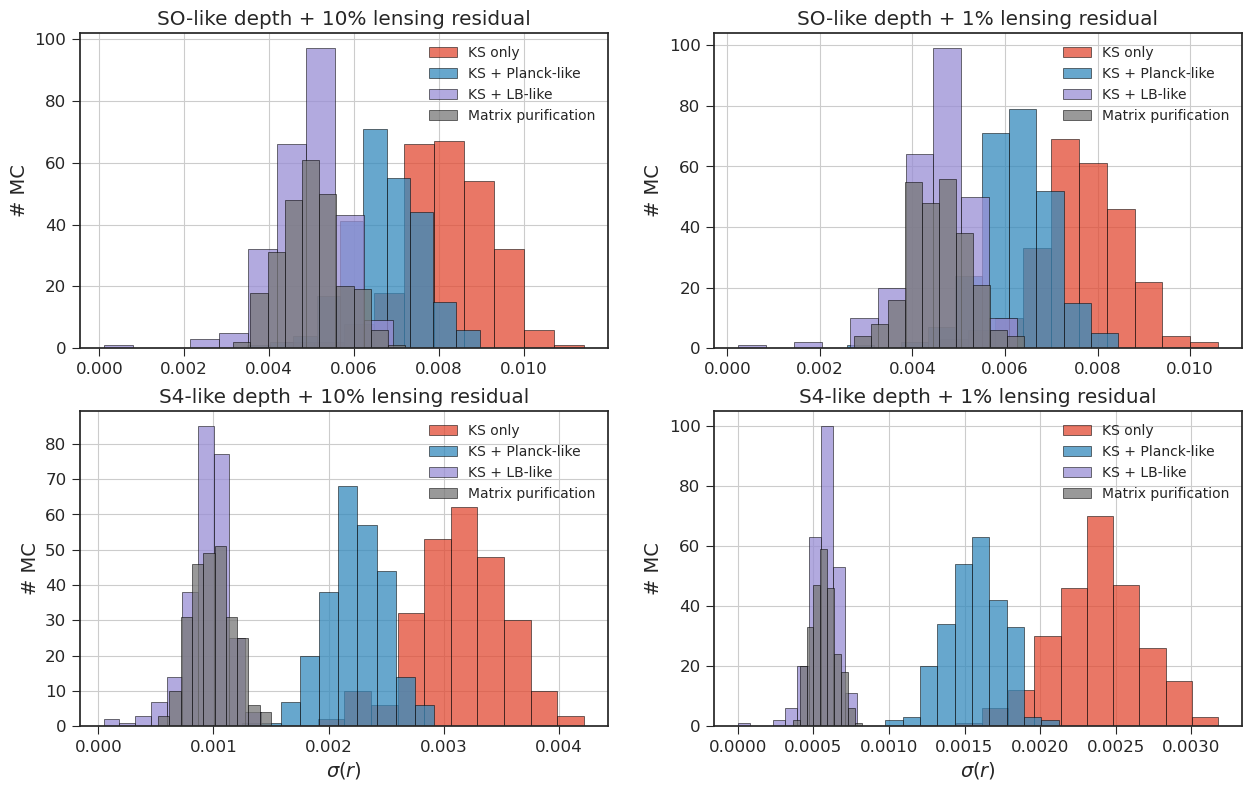

In [12]:
plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])

fig, axes = plt.subplots(2,2, figsize=(15,9))

axes[0][0].set_title('SO-like depth + 10% lensing residual')
axes[0][0].hist(SOten_r_KS, alpha=0.75, edgecolor='black', linewidth=0.5, label='KS only')
axes[0][0].hist(SOten_r_KS_planck, alpha=0.75, edgecolor='black', linewidth=0.5, label='KS + Planck-like')
axes[0][0].hist(SOten_r_KS_lb, alpha=0.75, edgecolor='black', linewidth=0.5, label='KS + LB-like')
axes[0][0].hist(SOten_r_matpure, alpha=0.75, edgecolor='black', linewidth=0.5, label='Matrix purification')

axes[0][1].set_title('SO-like depth + 1% lensing residual')
axes[0][1].hist(SOone_r_KS, alpha=0.75, edgecolor='black', linewidth=0.5, label='KS only')
axes[0][1].hist(SOone_r_KS_planck, alpha=0.75, edgecolor='black', linewidth=0.5, label='KS + Planck-like')
axes[0][1].hist(SOone_r_KS_lb, alpha=0.75, edgecolor='black', linewidth=0.5, label='KS + LB-like')
axes[0][1].hist(SOone_r_matpure, alpha=0.75, edgecolor='black', linewidth=0.5, label='Matrix purification')

axes[1][0].set_title('S4-like depth + 10% lensing residual')
axes[1][0].hist(S4ten_r_KS, alpha=0.75, edgecolor='black', linewidth=0.5, label='KS only')
axes[1][0].hist(S4ten_r_KS_planck, alpha=0.75, edgecolor='black', linewidth=0.5, label='KS + Planck-like')
axes[1][0].hist(S4ten_r_KS_lb, alpha=0.75, edgecolor='black', linewidth=0.5, label='KS + LB-like')
axes[1][0].hist(S4ten_r_matpure, alpha=0.75, edgecolor='black', linewidth=0.5, label='Matrix purification')
axes[1][0].set_xlabel('$\sigma(r)$', fontsize=14)

axes[1][1].set_title('S4-like depth + 1% lensing residual')
axes[1][1].hist(S4one_r_KS, alpha=0.75, edgecolor='black', linewidth=0.5, label='KS only')
axes[1][1].hist(S4one_r_KS_planck, alpha=0.75, edgecolor='black', linewidth=0.5, label='KS + Planck-like')
axes[1][1].hist(S4one_r_KS_lb, alpha=0.75, edgecolor='black', linewidth=0.5, label='KS + LB-like')
axes[1][1].hist(S4one_r_matpure, alpha=0.75, edgecolor='black', linewidth=0.5, label='Matrix purification')
axes[1][1].set_xlabel('$\sigma(r)$', fontsize=14)

for ax in axes.flatten():
    ax.grid()
    ax.set_ylabel('# MC', fontsize=14)
    ax.legend(fontsize=10, loc='best')
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

# plt.savefig('plots/fish.pdf', bbox_inches='tight')

In [13]:
# def pm(r):
#     p = [16, 50, 84]
#     lower, med, upper = np.percentile(r, p) * 1000
#     print(f'{med:.2}, {upper-med:.1}, {med-lower:.1}')

In [14]:
# pm(SOten_r_KS)
# pm(SOten_r_KS_planck)
# pm(SOten_r_KS_lb)
# pm(SOten_r_matpure)

In [15]:
# pm(SOone_r_KS)
# pm(SOone_r_KS_planck)
# pm(SOone_r_KS_lb)
# pm(SOone_r_matpure)

In [16]:
# pm(S4ten_r_KS)
# pm(S4ten_r_KS_planck)
# pm(S4ten_r_KS_lb)
# pm(S4ten_r_matpure)

In [17]:
# pm(S4one_r_KS)
# pm(S4one_r_KS_planck)
# pm(S4one_r_KS_lb)
# pm(S4one_r_matpure)

In [24]:
# def improv(x, ks):
#     print( f'{np.abs(np.median(x) - np.median(ks)) / np.median(ks) *100:.2}')

In [25]:
# improv(SOten_r_KS_planck, SOten_r_KS)
# improv(SOten_r_KS_lb, SOten_r_KS)
# improv(SOten_r_matpure, SOten_r_KS)

1.8e+01
3.8e+01
3.9e+01


In [26]:
# improv(SOone_r_KS_planck, SOone_r_KS)
# improv(SOone_r_KS_lb, SOone_r_KS)
# improv(SOone_r_matpure, SOone_r_KS)

1.8e+01
4e+01
4.1e+01


In [27]:
# improv(S4ten_r_KS_planck, S4ten_r_KS)
# improv(S4ten_r_KS_lb, S4ten_r_KS)
# improv(S4ten_r_matpure, S4ten_r_KS)

2.9e+01
6.9e+01
6.8e+01


In [28]:
# improv(S4one_r_KS_planck, S4one_r_KS)
# improv(S4one_r_KS_lb, S4one_r_KS)
# improv(S4one_r_matpure, S4one_r_KS)

3.3e+01
7.6e+01
7.6e+01


In [33]:
nmc_noise = 256

nl_SO = np.zeros((nmc_noise, len(ells)))
nl_S4 = np.zeros((nmc_noise, len(ells)))

for i in tqdm(range(nmc_noise)):
    obs_noise_unapo = hp.read_map(f'SO_opt/out/{i+1000}/filterbin_filtered_map.fits', field=None)
    f = nmt.NmtField(mask_apo, mask*obs_noise_unapo[1:], purify_b=True)
    nl_SO[i] = nmt.compute_full_master(f, f, b, workspace=w_KS)[3]
    
    obs_noise_unapo = hp.read_map(f'S4/out/{i+1000}/filterbin_filtered_map.fits', field=None)
    f = nmt.NmtField(mask_apo, mask*obs_noise_unapo[1:], purify_b=True)
    nl_S4[i] = nmt.compute_full_master(f, f, b, workspace=w_KS)[3]

nl_SO_mean = np.mean(nl_SO, axis=0)
nl_SO_std = np.std(nl_SO, axis=0)

nl_S4_mean = np.mean(nl_S4, axis=0)
nl_S4_std = np.std(nl_S4, axis=0)

100%|█████████████████████████████████████████| 256/256 [04:05<00:00,  1.04it/s]


(array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
 [Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'),
  Text(0, 1e-05, '$\\mathdefault{10^{-5}}$'),
  Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$')])

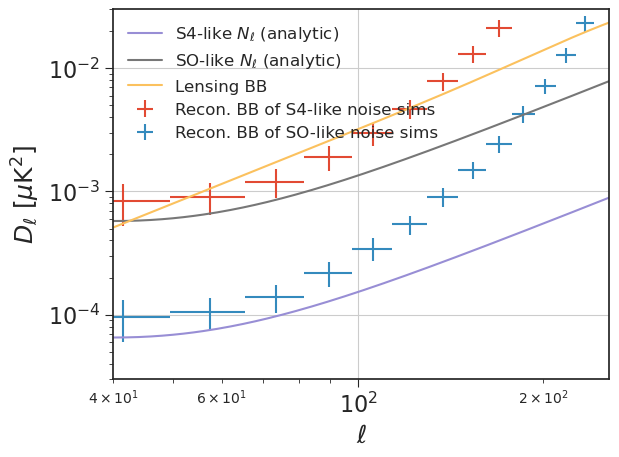

In [34]:
plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])

plt.errorbar(ells, c2db*nl_SO_mean, yerr=c2db*nl_SO_std, xerr=bin_size/2, linestyle='', label='Recon. BB of S4-like noise sims')
plt.errorbar(ells, c2db*nl_S4_mean, yerr=c2db*nl_S4_std, xerr=bin_size/2, linestyle='', label='Recon. BB of SO-like noise sims')

plt.plot(c2d*s4, label='S4-like $N_\ell$ (analytic)')
plt.plot(c2d*so, label='SO-like $N_\ell$ (analytic)')

plt.plot(c2d*input_cls_lcdm[2], label='Lensing BB')

plt.loglog()
plt.legend(fontsize=12)
plt.xlim([40, 2*nside])
plt.ylim([3e-5,3e-2])
plt.grid()
plt.ylabel('$D_\ell$ [$\mu$K$^2$]', fontsize=18)
plt.xlabel('$\ell$', fontsize=18)
# plt.title('BB spectra for filtered $\Lambda$CDM maps', fontsize=20, pad=15)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.savefig('plots/PS_noise.pdf', bbox_inches='tight')

In [22]:
SOten_mean_KS = c2db * np.mean(SOten_KS, axis=0)
SOten_std_KS = c2db * np.std(SOten_KS, axis=0)
      
SOten_mean_matpure = c2db * np.mean(SOten_matpure, axis=0)
SOten_std_matpure = c2db * np.std(SOten_matpure, axis=0)
      
SOten_mean_KS_planck = c2db * np.mean(SOten_KS_planck, axis=0)
SOten_std_KS_planck = c2db * np.std(SOten_KS_planck, axis=0)

SOten_mean_KS_lb = c2db * np.mean(SOten_KS_lb, axis=0)
SOten_std_KS_lb = c2db * np.std(SOten_KS_lb, axis=0)

SOone_mean_KS = c2db * np.mean(SOone_KS, axis=0)
SOone_std_KS = c2db * np.std(SOone_KS, axis=0)
      
SOone_mean_matpure = c2db * np.mean(SOone_matpure, axis=0)
SOone_std_matpure = c2db * np.std(SOone_matpure, axis=0)
      
SOone_mean_KS_planck = c2db * np.mean(SOone_KS_planck, axis=0)
SOone_std_KS_planck = c2db * np.std(SOone_KS_planck, axis=0)

SOone_mean_KS_lb = c2db * np.mean(SOone_KS_lb, axis=0)
SOone_std_KS_lb = c2db * np.std(SOone_KS_lb, axis=0)

S4ten_mean_KS = c2db * np.mean(S4ten_KS, axis=0)
S4ten_std_KS = c2db * np.std(S4ten_KS, axis=0)
      
S4ten_mean_matpure = c2db * np.mean(S4ten_matpure, axis=0)
S4ten_std_matpure = c2db * np.std(S4ten_matpure, axis=0)
      
S4ten_mean_KS_planck = c2db * np.mean(S4ten_KS_planck, axis=0)
S4ten_std_KS_planck = c2db * np.std(S4ten_KS_planck, axis=0)

S4ten_mean_KS_lb = c2db * np.mean(S4ten_KS_lb, axis=0)
S4ten_std_KS_lb = c2db * np.std(S4ten_KS_lb, axis=0)

S4one_mean_KS = c2db * np.mean(S4one_KS, axis=0)
S4one_std_KS = c2db * np.std(S4one_KS, axis=0)
      
S4one_mean_matpure = c2db * np.mean(S4one_matpure, axis=0)
S4one_std_matpure = c2db * np.std(S4one_matpure, axis=0)
      
S4one_mean_KS_planck = c2db * np.mean(S4one_KS_planck, axis=0)
S4one_std_KS_planck = c2db * np.std(S4one_KS_planck, axis=0)

S4one_mean_KS_lb = c2db * np.mean(S4one_KS_lb, axis=0)
S4one_std_KS_lb = c2db * np.std(S4one_KS_lb, axis=0)

NameError: name 'nl_SO_mean' is not defined

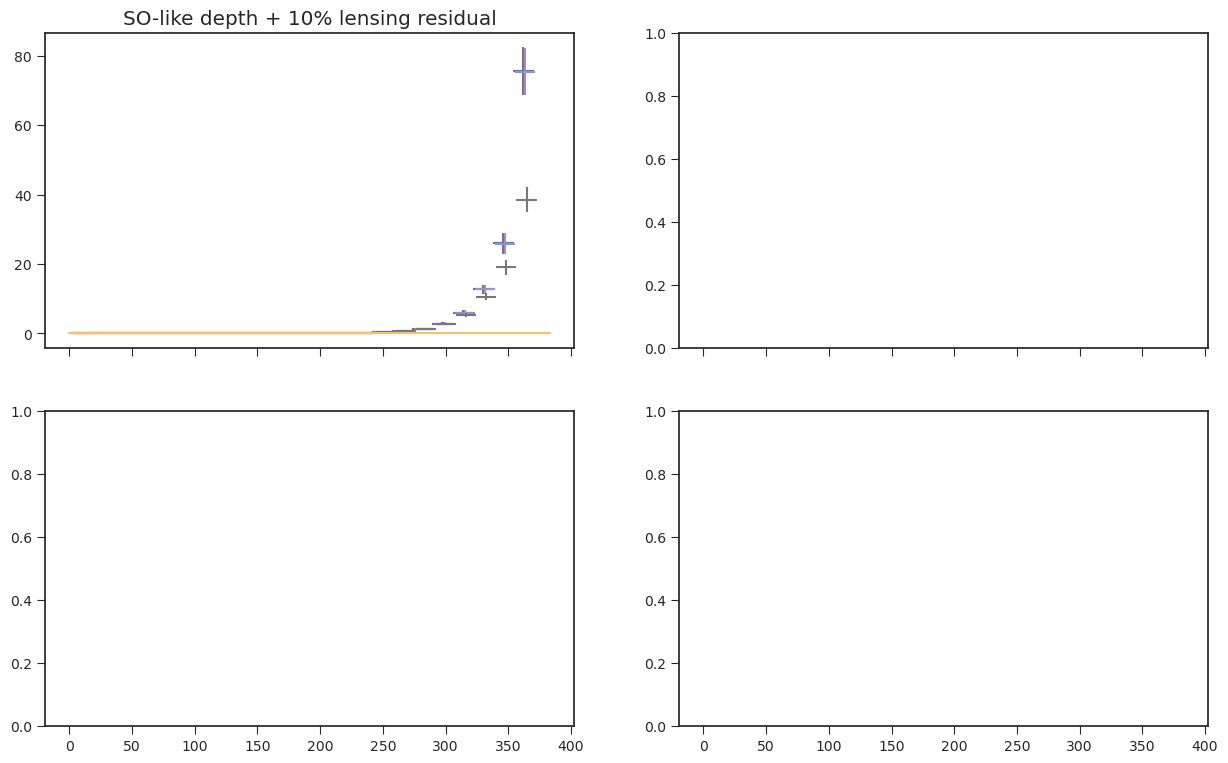

In [23]:
plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])

fig, axes = plt.subplots(2,2, figsize=(15,9), sharex=True)

axes[0][0].set_title('SO-like depth + 10% lensing residual')
axes[0][0].errorbar(ells, SOten_mean_KS, yerr=SOten_std_KS, xerr=bin_size/2, linestyle='', label='KS only')
axes[0][0].errorbar(ells+1, SOten_mean_KS_planck, yerr=SOten_std_KS_planck, xerr=bin_size/2, linestyle='', label='KS + Planck-like')
axes[0][0].errorbar(ells+2, SOten_mean_KS_lb, yerr=SOten_std_KS_lb, xerr=bin_size/2, linestyle='', label='KS + LB-like')
axes[0][0].errorbar(ells+3, SOten_mean_matpure, yerr=SOten_std_matpure, xerr=bin_size/2, linestyle='', label='Matrix purification')
axes[0][0].plot(c2d*lensingten[2], label='Lensing residual (10%)')
# axes[0][0].plot(c2d*so/bl**2, label='SO-like $N_\ell$ (w/ deg beam)')
axes[0][0].plot(ells, c2db*nl_SO_mean, label='SO-like noise')
axes[0][0].set_ylim([5e-4, 5e-2])

axes[0][1].set_title('SO-like depth + 1% lensing residual')
axes[0][1].errorbar(ells, SOone_mean_KS, yerr=SOone_std_KS, xerr=bin_size/2, linestyle='', label='KS only')
axes[0][1].errorbar(ells+1, SOone_mean_KS_planck, yerr=SOone_std_KS_planck, xerr=bin_size/2, linestyle='', label='KS + Planck-like')
axes[0][1].errorbar(ells+2, SOone_mean_KS_lb, yerr=SOone_std_KS_lb, xerr=bin_size/2, linestyle='', label='KS + LB-like')
axes[0][1].errorbar(ells+3, SOone_mean_matpure, yerr=SOone_std_matpure, xerr=bin_size/2, linestyle='', label='Matrix purification')
axes[0][1].plot(c2d*lensingone[2])#, label='Lensing residual (1%), off screen')
# axes[0][1].plot(c2d*so/bl**2, label='SO-like $N_\ell$ (w/ deg beam)')
axes[0][1].plot(ells, c2db*nl_SO_mean, label='SO-like noise')
axes[0][1].set_ylim([5e-4, 5e-2])

axes[1][0].set_title('S4-like depth + 10% lensing residual')
axes[1][0].errorbar(ells, S4ten_mean_KS, yerr=S4ten_std_KS, xerr=bin_size/2, linestyle='', label='KS only')
axes[1][0].errorbar(ells+1, S4ten_mean_KS_planck, yerr=S4ten_std_KS_planck, xerr=bin_size/2, linestyle='', label='KS + Planck-like')
axes[1][0].errorbar(ells+2, S4ten_mean_KS_lb, yerr=S4ten_std_KS_lb, xerr=bin_size/2, linestyle='', label='KS + LB-like')
axes[1][0].errorbar(ells+3, S4ten_mean_matpure, yerr=S4ten_std_matpure, xerr=bin_size/2, linestyle='', label='Matrix purification')
axes[1][0].plot(c2d*lensingten[2], label='Lensing residual (10%)')
# axes[1][0].plot(c2d*s4/bl**2, label='S4-like $N_\ell$ (w/ deg beam)')
axes[1][0].plot(ells, c2db*nl_S4_mean, label='S4-like noise')
axes[1][0].set_ylim([5e-5, 5e-3])

axes[1][1].set_title('S4-like depth + 1% lensing residual')
axes[1][1].errorbar(ells, S4one_mean_KS, yerr=S4one_std_KS, xerr=bin_size/2, linestyle='', label='KS only')
axes[1][1].errorbar(ells+1, S4one_mean_KS_planck, yerr=S4one_std_KS_planck, xerr=bin_size/2, linestyle='', label='KS + Planck-like')
axes[1][1].errorbar(ells+2, S4one_mean_KS_lb, yerr=S4one_std_KS_lb, xerr=bin_size/2, linestyle='', label='KS + LB-like')
axes[1][1].errorbar(ells+3, S4one_mean_matpure, yerr=S4one_std_matpure, xerr=bin_size/2, linestyle='', label='Matrix purification')
axes[1][1].plot(c2d*lensingone[2], label='Lensing residual (1%)')
# axes[1][1].plot(c2d*s4/bl**2, label='S4-like $N_\ell$ (w/ deg beam)')
axes[1][1].plot(ells, c2db*nl_S4_mean, label='S4-like noise')
axes[1][1].set_ylim([5e-5, 5e-3])

for ax in axes.flatten():
    ax.set_xlim([40, 2*nside])
    ax.grid()
    ax.loglog()
    ax.set_ylabel('$D_\ell$ [$\mu$K$^2$]', fontsize=14)
    ax.set_xlabel('$\ell$', fontsize=14)
    ax.legend(fontsize=10, loc='lower right')
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

# plt.savefig('plots/PS.pdf', bbox_inches='tight')

In [29]:
mode='leakage'
cl_KS = np.load(f'apo{apo_size}/{mode}_KS.npy')
cl_KS_planck = np.load(f'apo{apo_size}/{mode}_KS_planck.npy')
cl_KS_lb = np.load(f'apo{apo_size}/{mode}_KS_lb.npy')
cl_matpure = np.load(f'apo{apo_size}/{mode}_matpure.npy')

In [30]:
mean_KS = c2db * np.mean(cl_KS, axis=0)
std_KS = c2db * np.std(cl_KS, axis=0)
      
mean_matpure = c2db * np.mean(cl_matpure, axis=0)
std_matpure = c2db * np.std(cl_matpure, axis=0)
      
mean_KS_planck = c2db * np.mean(cl_KS_planck, axis=0)
std_KS_planck = c2db * np.std(cl_KS_planck, axis=0)

mean_KS_lb = c2db * np.mean(cl_KS_lb, axis=0)
std_KS_lb = c2db * np.std(cl_KS_lb, axis=0)

In [33]:
r0p01 = mylib.get_camb(Alens=0, r=1e-2, lmax=lmax)
r0p001 = mylib.get_camb(Alens=0, r=1e-3, lmax=lmax)

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01]),
 [Text(0, 1e-10, '$\\mathdefault{10^{-10}}$'),
  Text(0, 1e-09, '$\\mathdefault{10^{-9}}$'),
  Text(0, 1e-08, '$\\mathdefault{10^{-8}}$'),
  Text(0, 1e-07, '$\\mathdefault{10^{-7}}$'),
  Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'),
  Text(0, 1e-05, '$\\mathdefault{10^{-5}}$'),
  Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$')])

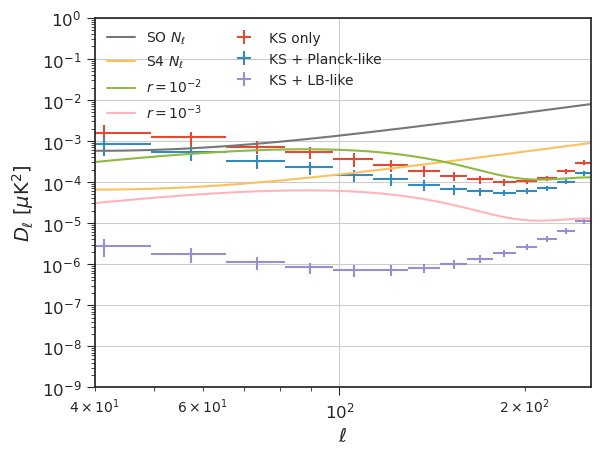

In [43]:
plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])
plt.errorbar(ells, mean_KS, yerr=std_KS, xerr=bin_size/2, linestyle='', label='KS only')
plt.errorbar(ells, mean_KS_planck, yerr=std_KS_planck, xerr=bin_size/2, linestyle='', label='KS + Planck-like')
plt.errorbar(ells, mean_KS_lb, yerr=std_KS_lb, xerr=bin_size/2, linestyle='', label='KS + LB-like')
# plt.errorbar(ells, mean_matpure, yerr=std_matpure, xerr=bin_size/2, linestyle='', label='Matrix purification')
# plt.plot(c2d*input_cls_lcdm[2], label='Lensing BB')
plt.plot(c2d*so, label='SO $N_\ell$')
plt.plot(c2d*s4, label='S4 $N_\ell$')
plt.plot(c2d*r0p01[2], label='$r=10^{-2}$')
plt.plot(c2d*r0p001[2], label='$r=10^{-3}$')

plt.xlim([40, 2*nside])
plt.ylim([1e-9, 1e-0])
plt.grid()
plt.loglog()
plt.ylabel('$D_\ell$ [$\mu$K$^2$]', fontsize=14)
plt.xlabel('$\ell$', fontsize=14)
plt.legend(ncol=2, fontsize=10, loc='upper left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plt.savefig('plots/PS_leakage.pdf', bbox_inches='tight')

[]

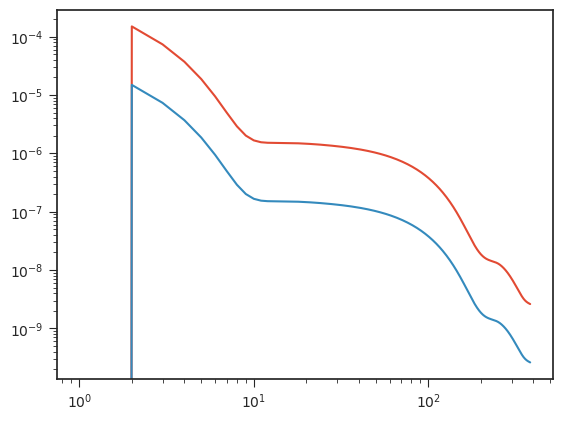

In [42]:
plt.plot(r0p01[2])
plt.plot(r0p001[2])
plt.loglog()

In [12]:
# nside = 8
# npix = 12*nside**2

In [10]:
# Cl_EEonly = obs_cov.get_Cl(nside, 'E')
# C_E = obs_cov.C_ana(nside, Cl_EEonly, None)

/scratch/yuyang/filterbin/obs_cov.py:12: RuntimeWarning: divide by zero encountered in divide
  C_l = 1/l**2
  0%|                                                   | 0/768 [00:00<?, ?it/s]/scratch/yuyang/filterbin/obs_cov.py:57: RuntimeWarning: invalid value encountered in divide
  F = 2 * ( ((l+2)*z)/(1-z**2) * P_l2(l-1,z) - ((l-4)/(1-z**2) + l*(l-1)/2) * P_l2(l,z) ) / ((l-1)*l*(l+1)*(l+2))
/scratch/yuyang/filterbin/obs_cov.py:68: RuntimeWarning: invalid value encountered in divide
  F = 4 * ( (l+2)*P_l2(l-1,z) - (l-1)*z*P_l2(l,z) ) / ( (l-1)*l*(l+1)*(l+2)*(1-z**2) )
100%|█████████████████████████████████████████| 768/768 [11:02<00:00,  1.16it/s]


In [50]:
# plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])
# plt.imshow(C_E[:npix, :npix], cmap='coolwarm')
# plt.xlabel('Pixel #')
# plt.ylabel('Pixel #')
# plt.colorbar()

# plt.savefig('plots/qq_cov.pdf', bbox_inches='tight')

In [28]:
# def cov_mc(nside, nmc):
#     npix = 12*nside**2
#     Cl_EEonly = obs_cov.get_Cl(nside, 'E')

#     C = np.zeros((2*npix, 2*npix))
#     for i in range(nmc):
#         m = hp.synfast(Cl_EEonly, nside, new=True)
#         C += np.outer(m[1:], m[1:])

#     C /= nmc
#     return C 

In [86]:
# C_mc = cov_mc(nside, nmc=npix)

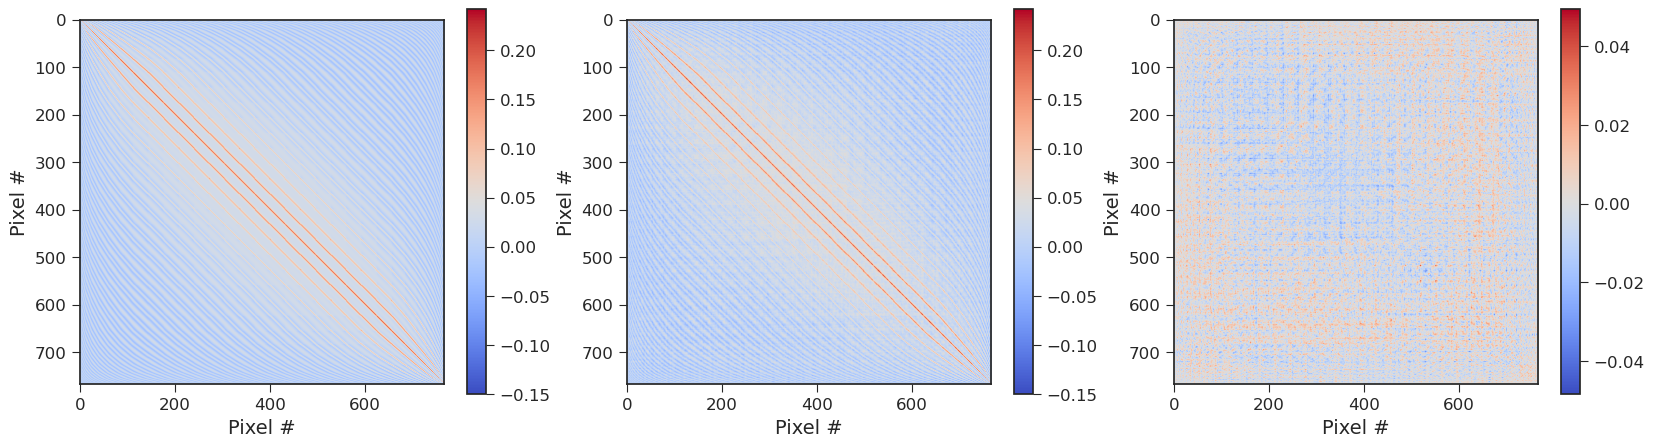

In [89]:
# plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])

# fig, axes = plt.subplots(1,3, figsize=(20,5))

# C_E = C_E[:npix, :npix]
# C_mc = C_mc[:npix, :npix]
# diff = C_E - C_mc

# ana = axes[0].imshow(C_E, cmap='coolwarm')
# mc = axes[1].imshow(C_mc, cmap='coolwarm', vmin=C_E.min(), vmax=C_E.max())
# d = axes[2].imshow(diff, cmap='coolwarm')

# for ax in axes:
#     ax.set_xlabel('Pixel #', fontsize=14)
#     ax.set_ylabel('Pixel #', fontsize=14)
#     ax.tick_params(axis='x', labelsize=12)
#     ax.tick_params(axis='y', labelsize=12)

# a = fig.colorbar(ana, ax=axes[0])
# b = fig.colorbar(mc, ax=axes[1])
# c = fig.colorbar(d, ax=axes[2])

# a.ax.tick_params(labelsize=12)
# b.ax.tick_params(labelsize=12)
# c.ax.tick_params(labelsize=12)

# plt.savefig('thesis_plots/cov_mc.pdf', bbox_inches='tight')

In [38]:
prefix = 'apo10'
eigs = np.load(f'{prefix}/eigenvalues.npy')
v = np.load(f'{prefix}/eigenvectors.npy')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


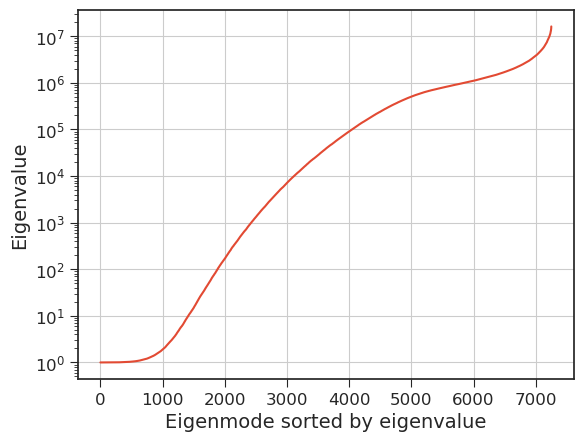

In [39]:
plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])
plt.plot(eigs)
plt.grid()
plt.semilogy()
plt.ylabel('Eigenvalue', fontsize=14)
plt.xlabel('Eigenmode sorted by eigenvalue', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('plots/eigs.pdf', bbox_inches='tight')

In [40]:
mask_QU = np.concatenate([mask, mask])
zeros = np.where(mask_QU==0)[0]

e1 = v[:,-1]
e0 = v[:,-6844]

e1[zeros] = 0
e0[zeros] = 0

e1 /= np.linalg.norm(e1, axis=0)
e0 /= np.linalg.norm(e0, axis=0)

T_pad = np.zeros(npix)
e1 = np.concatenate([T_pad, e1])
e0 = np.concatenate([T_pad, e0])

e0 = e0.reshape(3,npix)
e1 = e1.reshape(3,npix)

b0 = mylib.get_Bmap(e0)
b1 = mylib.get_Bmap(e1)

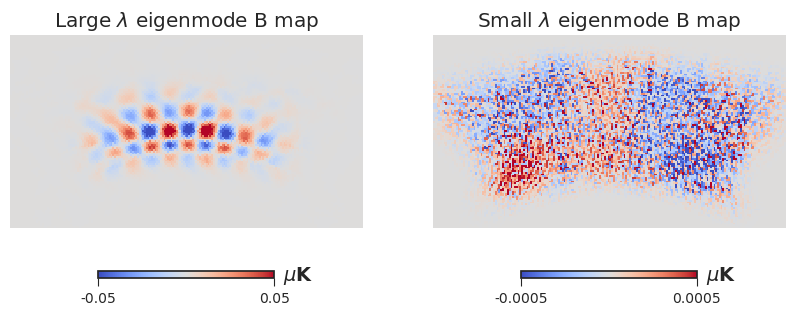

In [41]:
fig, axes = plt.subplots(1,2, figsize=(10,7))

plt.axes(axes[0])
hp.gnomview(mask_apo*b1, cmap='coolwarm', min=-5e-2, max=5e-2, rot=(40,-42), reso=20, ysize=110, unit='$\mu$K', title=f'Large $\lambda$ eigenmode B map', notext=True, hold=True)

plt.axes(axes[1])
hp.gnomview(mask_apo*b0, cmap='coolwarm', min=-5e-4, max=5e-4, rot=(40,-42), reso=20, ysize=110, unit='$\mu$K', title=f'Small $\lambda$ eigenmode B map', notext=True, hold=True)

plt.savefig('plots/eigv.pdf', bbox_inches='tight')

In [8]:
nside = 256
lmax = 3*nside-1
l = np.arange(lmax+1)

cl_r1 = mylib.get_camb(0, 1, lmax) 
s4 = mylib.get_Nl([1, 50, -3], lmax)
so = mylib.get_Nl([np.sqrt(2)*2.1, 50, -3], lmax)

def sigma(ell_min, fsky, nl):
    return 1/np.sqrt(fsky/2 * np.sum( 2*l[ell_min:]+1 * (cl_r1[2][ell_min:]/nl[ell_min:])**2) )

In [9]:
ell_min = np.arange(100)

s_s4 = []
s_so = []
for lmin in ell_min:
    s_so.append(sigma(lmin, 0.1, so))
    s_s4.append(sigma(lmin, 0.03, s4))

/tmp/ipykernel_48738/1683097202.py:10: RuntimeWarning: invalid value encountered in divide
  return 1/np.sqrt(fsky/2 * np.sum( 2*l[ell_min:]+1 * (cl_r1[2][ell_min:]/nl[ell_min:])**2) )


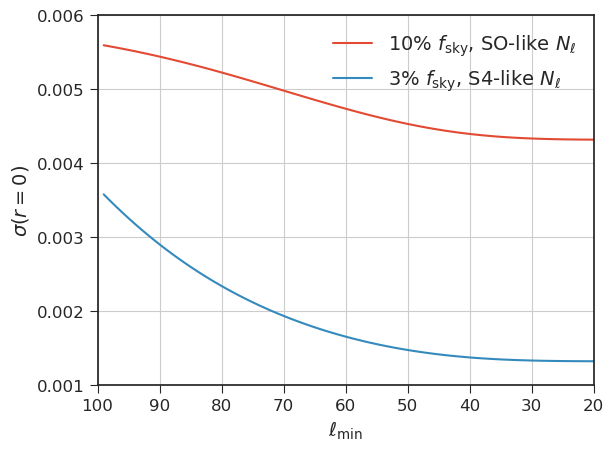

In [26]:
plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])
plt.plot(ell_min, s_so, label='10% $f_\mathrm{sky}$, SO-like $N_\ell$')
plt.plot(ell_min, s_s4, label='3% $f_\mathrm{sky}$, S4-like $N_\ell$')

plt.grid()
plt.xlabel('$\ell_\mathrm{min}$', fontsize=14)
plt.ylabel('$\sigma(r=0)$', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_xaxis()
plt.ylim([1e-3,6e-3])
plt.xlim([100,20])
# plt.semilogy()

plt.savefig('thesis_plots/lmin.pdf', bbox_inches='tight')

In [8]:
nmc=30

cl_bb = np.zeros((6, lmax+1))
cl_ee = np.zeros((6, lmax+1))

for i in tqdm(range(nmc)):
    np.random.seed(i)
    m_bb = (R @ hp.synfast(input_cls_noEE, nside, new=True).flatten()).reshape(3, npix)
    m_ee = (R @ hp.synfast(input_cls_noBB, nside, new=True).flatten()).reshape(3, npix)

    pure_m_bb = np.copy(m_bb)
    pure_m_ee = np.copy(m_ee)

    for j, n_v in enumerate([100, 300, 500, 1000, 3000, 5000]):
        pi_b = sp.sparse.load_npz(f'apo{apo_size}/pi_b_{n_v}.npz')
        pure_m_bb[1:] = (pi_b @ m_bb[1:].flatten()).reshape(2,npix)
        pure_m_ee[1:] = (pi_b @ m_ee[1:].flatten()).reshape(2,npix)

        cl_bb[j] += hp.anafast(pure_m_bb)[2]
        cl_ee[j] += hp.anafast(pure_m_ee)[2]

cl_bb /= nmc
cl_ee /= nmc

100%|████████████████████████████████████████| 30/30 [1:23:16<00:00, 166.57s/it]


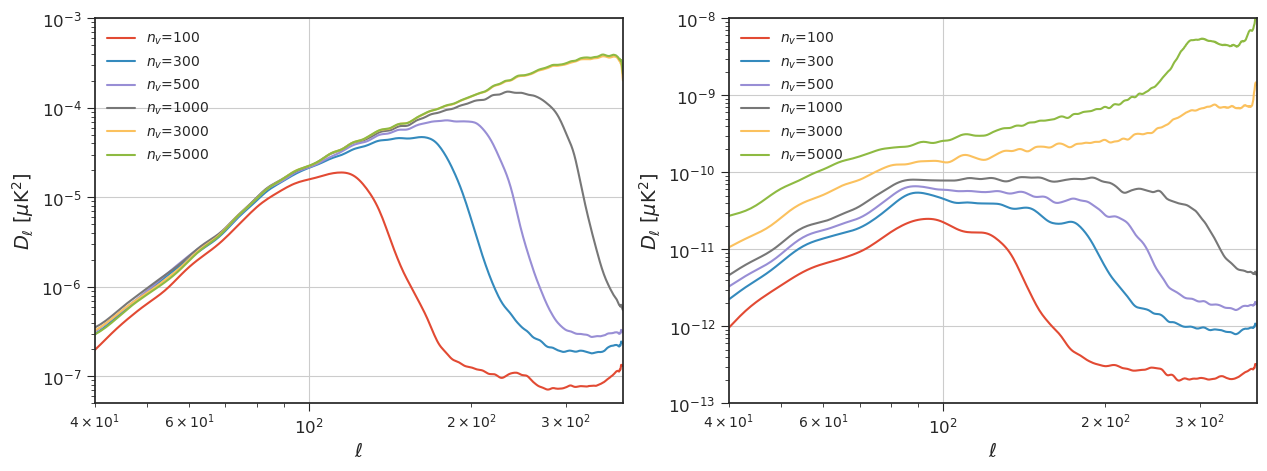

In [9]:
plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])

fig, axes = plt.subplots(1,2, figsize=(15,5))

for i, n_v in enumerate([100, 300, 500, 1000, 3000, 5000]):
    axes[0].plot(c2d*cl_bb[i], label=f'$n_v$={n_v}')
    axes[1].plot(c2d*cl_ee[i], label=f'$n_v$={n_v}')

axes[0].set_ylim([5e-8,1e-3])
axes[1].set_ylim([1e-13,1e-8])

for ax in axes.flatten():
    ax.loglog()
    ax.legend(fontsize=10)
    ax.set_xlim([40, lmax])
    ax.grid()
    ax.set_ylabel('$D_\ell$ [$\mu$K$^2$]', fontsize=14)
    ax.set_xlabel('$\ell$', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

plt.savefig('plots/mat.pdf', bbox_inches='tight')

In [8]:
np.random.seed(0)
signal = hp.synfast(input_cls_noBB, nside, fwhm=fwhm, new=True)
planck_noise = hp.synfast(planck_noise_cls, nside, new=True)
lb_noise = hp.synfast(lb_noise_cls, nside, new=True)

planck_E = signal + planck_noise
lb_E = signal + lb_noise

wienered_planck = mylib.wiener_filter(planck_E, input_cls_noBB*bl**2, planck_noise_cls)
wienered_lb = mylib.wiener_filter(lb_E, input_cls_noBB*bl**2, lb_noise_cls)

/scratch/yuyang/filterbin/mylib.py:83: RuntimeWarning: invalid value encountered in divide
  W_11 = (signal_cl[1] * full_cl[0] - signal_cl[3]*full_cl[3]) / (full_cl[1] * full_cl[0] - full_cl[3]**2)
/scratch/yuyang/filterbin/mylib.py:84: RuntimeWarning: invalid value encountered in divide
  W_01 = (signal_cl[3] * full_cl[1] - signal_cl[1]*full_cl[3]) / (full_cl[1] * full_cl[0] - full_cl[3]**2)


In [9]:
temp_planck = (R_unapo @ wienered_planck.flatten()).reshape(3, npix) 
temp_lb = (R_unapo @ wienered_lb.flatten()).reshape(3, npix) 
temp_noiseless = (R_unapo @ signal.flatten()).reshape(3, npix) 

leakage_planck = hp.alm2map(hp.map2alm(temp_planck)[2], nside)
leakage_lb = hp.alm2map(hp.map2alm(temp_lb)[2], nside)
leakage_noiseless = hp.alm2map(hp.map2alm(temp_noiseless)[2], nside)

In [10]:
matpure = mask_apo * temp_noiseless
matpure[1:] = (pi_b @ matpure[1:].flatten()).reshape(2, npix) 

In [11]:
# scale=0.5
# hp.gnomview(hp.alm2map(hp.map2alm((R_unapo @ signal.flatten()).reshape(3, npix))[2], nside) , cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='BB leakage template filtered', notext=True)
# hp.gnomview(hp.alm2map(hp.map2alm(mask*signal)[2], nside)  , cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='BB leakage template masked', notext=True)

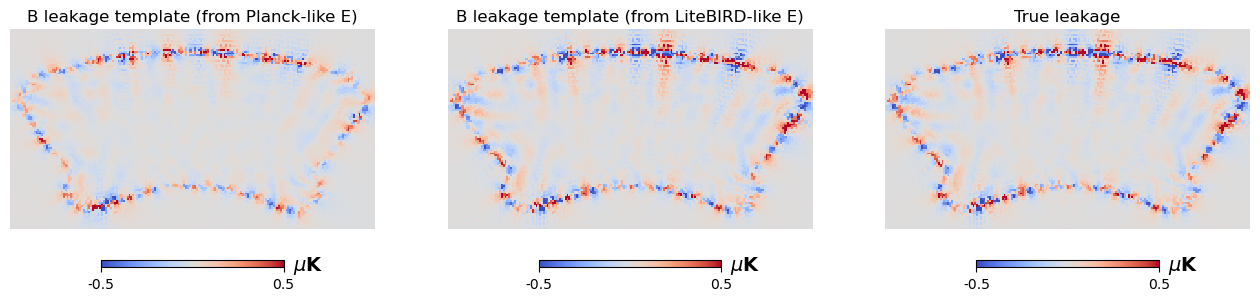

In [12]:
scale=0.5

fig, axes = plt.subplots(1,3, figsize=(16,5))

plt.axes(axes[0])
hp.gnomview(leakage_planck, cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='B leakage template (from Planck-like E)', notext=True, hold=True)

plt.axes(axes[1])
hp.gnomview(leakage_lb, cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='B leakage template (from LiteBIRD-like E)', notext=True, hold=True)

plt.axes(axes[2])
hp.gnomview(leakage_noiseless, cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='True leakage', notext=True, hold=True)
plt.savefig('plots/template.pdf', bbox_inches='tight')

NameError: name 'matpure' is not defined

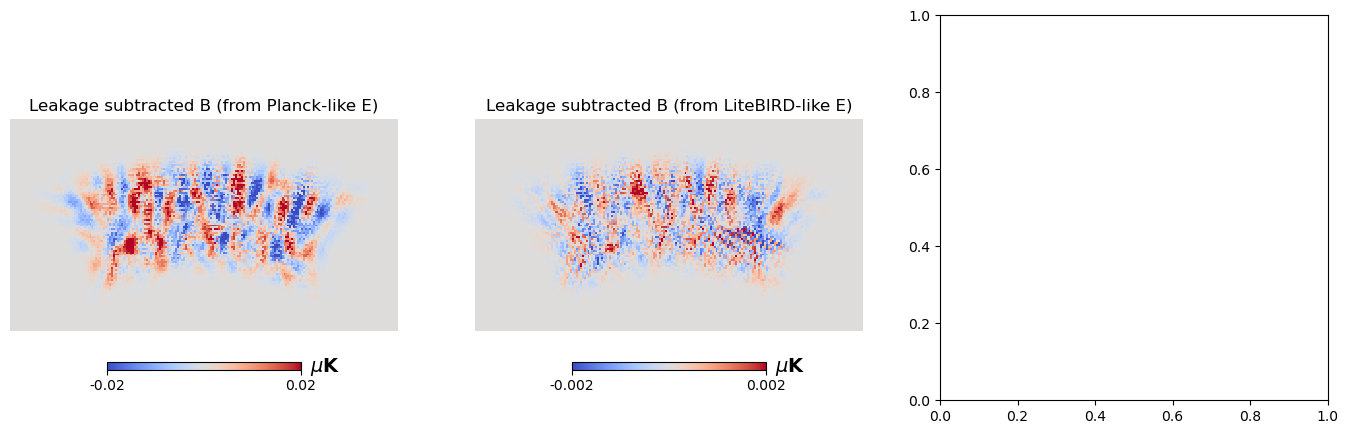

In [10]:
scale=2e-2
fig, axes = plt.subplots(1,3, figsize=(17,5))
plt.axes(axes[0])
hp.gnomview(mask_apo * (leakage_noiseless - leakage_planck), cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='Leakage subtracted B (from Planck-like E)', notext=True, hold=True)

scale=2e-3
plt.axes(axes[1])
hp.gnomview(mask_apo * (leakage_noiseless - leakage_lb), cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='Leakage subtracted B (from LiteBIRD-like E)', notext=True, hold=True)

scale=2e-4
plt.axes(axes[2])
hp.gnomview(mylib.get_Bmap(matpure), cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='Matrix purified B', notext=True, hold=True)
# plt.savefig('plots/leakage_sub.pdf', bbox_inches='tight')

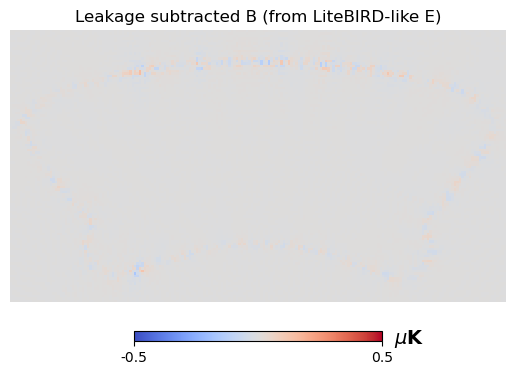

In [19]:
#for the lbl talk
scale = 0.5
hp.gnomview(leakage_noiseless - leakage_lb, cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='Leakage subtracted B (from LiteBIRD-like E)', notext=True, hold=True)

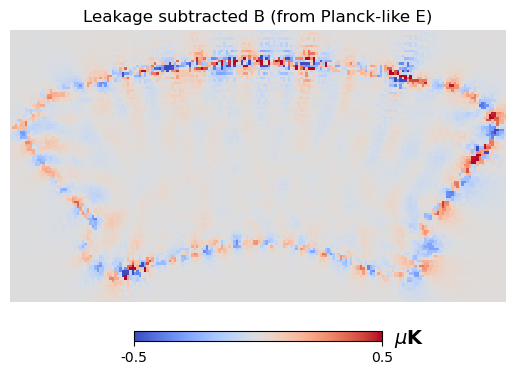

In [18]:
hp.gnomview(leakage_noiseless - leakage_planck, cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='Leakage subtracted B (from Planck-like E)', notext=True, hold=True)

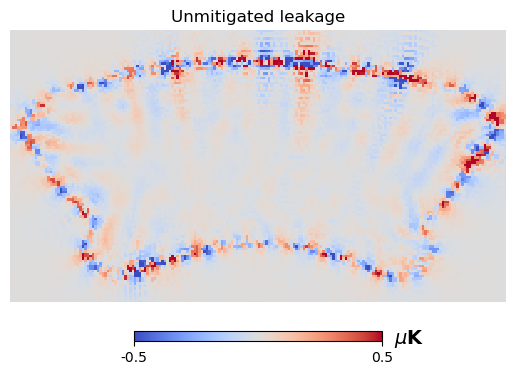

In [17]:
hp.gnomview(leakage_noiseless, cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='Unmitigated leakage', notext=True, hold=True)

In [50]:
EE_signal = np.zeros(lmax+1)
EE_noise = np.zeros(lmax+1)
EE_full = np.zeros(lmax+1)
EE_wienered = np.zeros(lmax+1)

for i in tqdm(range(128)):
    signal = hp.synfast(input_cls_noBB, nside, fwhm=fwhm, new=True)
    noise = hp.synfast(planck_noise_cls, nside, new=True)
    # noise = hp.synfast(lb_noise_cls, nside, new=True)

    noisy_E = signal + noise
    wienered_E = mylib.wiener_filter(noisy_E, input_cls_noBB*bl**2, planck_noise_cls)

    EE_signal += hp.anafast(signal)[1]
    EE_noise += hp.anafast(noise)[1]
    EE_full += hp.anafast(noisy_E)[1]
    EE_wienered += hp.anafast(wienered_E)[1]

EE_signal/=100
EE_noise/=100
EE_full/=100
EE_wienered/=100

  0%|                                                   | 0/128 [00:00<?, ?it/s]/scratch/yuyang/filterbin/mylib.py:83: RuntimeWarning: invalid value encountered in divide
  W_11 = (signal_cl[1] * full_cl[0] - signal_cl[3]*full_cl[3]) / (full_cl[1] * full_cl[0] - full_cl[3]**2)
/scratch/yuyang/filterbin/mylib.py:84: RuntimeWarning: invalid value encountered in divide
  W_01 = (signal_cl[3] * full_cl[1] - signal_cl[1]*full_cl[3]) / (full_cl[1] * full_cl[0] - full_cl[3]**2)
100%|█████████████████████████████████████████| 128/128 [02:05<00:00,  1.02it/s]


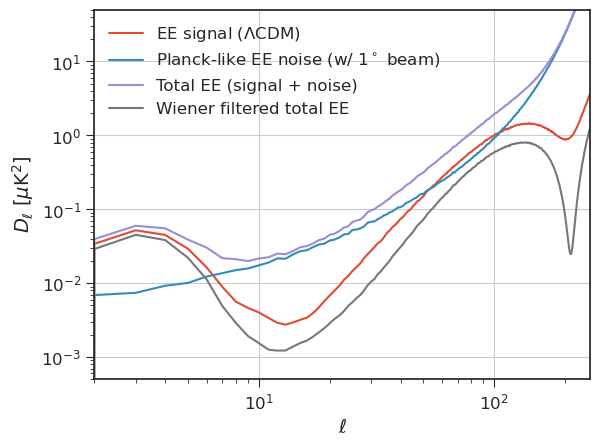

In [51]:
plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])

plt.plot(c2d*EE_signal/bl**2, label='EE signal ($\Lambda$CDM)')
plt.plot(c2d*EE_noise/bl**2, label='Planck-like EE noise (w/ $1^\circ$ beam)')
plt.plot(c2d*EE_full/bl**2, label='Total EE (signal + noise)')
plt.plot(c2d*EE_wienered/bl**2, label='Wiener filtered total EE')
plt.loglog()

plt.legend(fontsize=12, loc='upper left')
plt.xlim([2,2*nside])
plt.ylim([5e-4,5e1])
plt.grid()
plt.ylabel('$D_\ell$ [$\mu$K$^2$]', fontsize=14)
plt.xlabel('$\ell$', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('plots/PS_wiener.pdf', bbox_inches='tight')

In [52]:
SO_noise = mask * hp.read_map(f'SO_opt/out/{1000}/filterbin_filtered_map.fits', field=None)
S4_noise = mask * hp.read_map(f'S4/out/{1000}/filterbin_filtered_map.fits', field=None)

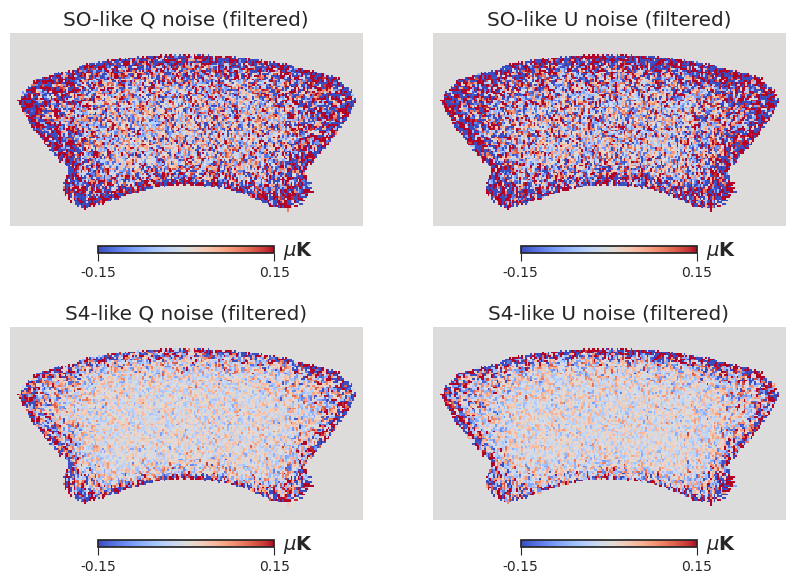

In [53]:
SO_scale = 0.15
S4_scale = 0.15

fig, axes = plt.subplots(2,2, figsize=(10,7))

plt.axes(axes[0][0])
hp.gnomview(SO_noise[1], cmap='coolwarm', min=-SO_scale, max=SO_scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='SO-like Q noise (filtered)', notext=True, hold=True)

plt.axes(axes[0][1])
hp.gnomview(SO_noise[2], cmap='coolwarm', min=-SO_scale, max=SO_scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='SO-like U noise (filtered)', notext=True, hold=True)

plt.axes(axes[1][0])
hp.gnomview(S4_noise[1], cmap='coolwarm', min=-S4_scale, max=S4_scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='S4-like Q noise (filtered)', notext=True, hold=True)

plt.axes(axes[1][1])
hp.gnomview(S4_noise[2], cmap='coolwarm', min=-S4_scale, max=S4_scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='S4-like U noise (filtered)', notext=True, hold=True)

plt.savefig('plots/noise.pdf', bbox_inches='tight')

In [54]:
np.random.seed(0)
signal = hp.synfast(input_cls_noBB, nside, fwhm=fwhm, new=True)
planck_noise = hp.synfast(planck_noise_cls, nside, new=True)

noisy_E = signal + planck_noise
wienered_E = mylib.wiener_filter(noisy_E, input_cls_noBB*bl**2, planck_noise_cls)

noisy_E = hp.alm2map(hp.map2alm(noisy_E)[1], nside)
wienered_E = hp.alm2map(hp.map2alm(wienered_E)[1], nside)

/scratch/yuyang/filterbin/mylib.py:83: RuntimeWarning: invalid value encountered in divide
  W_11 = (signal_cl[1] * full_cl[0] - signal_cl[3]*full_cl[3]) / (full_cl[1] * full_cl[0] - full_cl[3]**2)
/scratch/yuyang/filterbin/mylib.py:84: RuntimeWarning: invalid value encountered in divide
  W_01 = (signal_cl[3] * full_cl[1] - signal_cl[1]*full_cl[3]) / (full_cl[1] * full_cl[0] - full_cl[3]**2)


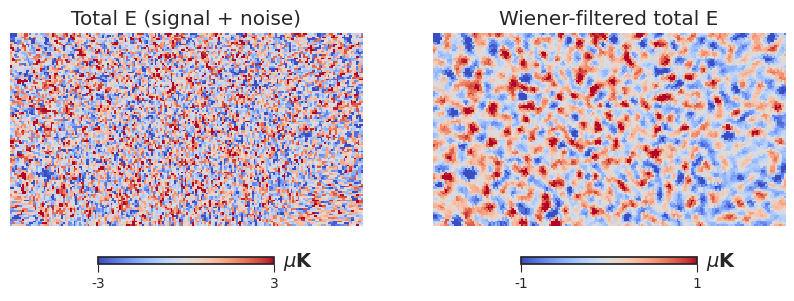

In [55]:
scale=3

fig, axes = plt.subplots(1,2, figsize=(10,5))

plt.axes(axes[0])
hp.gnomview(noisy_E, cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='Total E (signal + noise)', notext=True, hold=True)

plt.axes(axes[1])
hp.gnomview(wienered_E, cmap='coolwarm', min=-1, max=1, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='Wiener-filtered total E', notext=True, hold=True)
plt.savefig('plots/wiener.pdf', bbox_inches='tight')

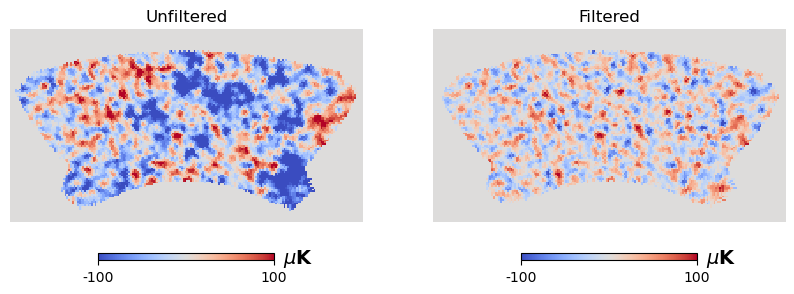

In [31]:
np.random.seed(3)
signal = hp.synfast(input_cls_lcdm, nside, fwhm=fwhm, new=True)
obs_m = (R_unapo @ signal.flatten()).reshape(3, npix)
masked_m = mask * signal

scale=100

fig, axes = plt.subplots(1,2, figsize=(10,5))

plt.axes(axes[0])
hp.gnomview(masked_m[0], cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='Unfiltered', notext=True, hold=True)

plt.axes(axes[1])
hp.gnomview(obs_m[0], cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='Filtered', notext=True, hold=True)
plt.savefig('thesis_plots/filtered_T.pdf', bbox_inches='tight')

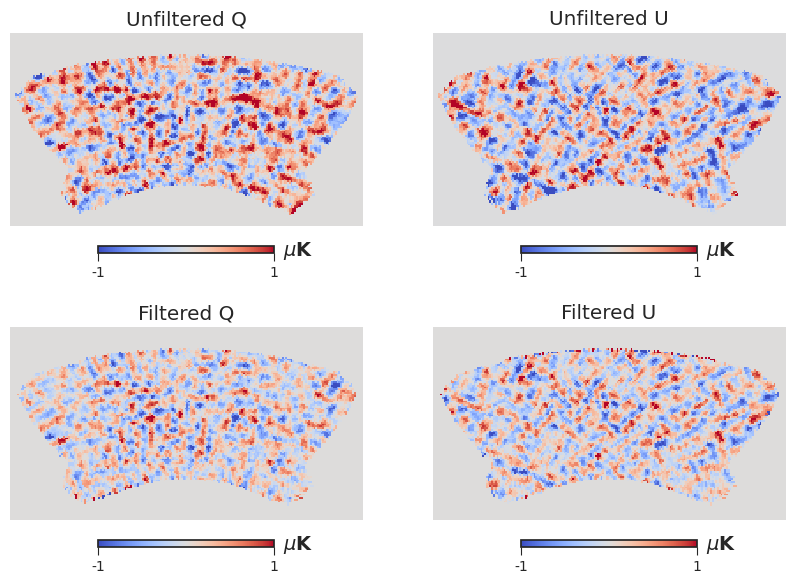

In [56]:
np.random.seed(0)
signal = hp.synfast(input_cls_lcdm, nside, fwhm=fwhm, new=True)
obs_m = (R_unapo @ signal.flatten()).reshape(3, npix)
masked_m = mask * signal

scale=1

fig, axes = plt.subplots(2,2, figsize=(10,7))

plt.axes(axes[0][0])
hp.gnomview(masked_m[1], cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='Unfiltered Q', notext=True, hold=True)

plt.axes(axes[0][1])
hp.gnomview(masked_m[2], cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='Unfiltered U', notext=True, hold=True)

plt.axes(axes[1][0])
hp.gnomview(obs_m[1], cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='Filtered Q', notext=True, hold=True)

plt.axes(axes[1][1])
hp.gnomview(obs_m[2], cmap='coolwarm', min=-scale, max=scale, rot=(40,-42), reso=25, ysize=110, unit='$\mu$K', title='Filtered U', notext=True, hold=True)

plt.savefig('plots/filtered.pdf', bbox_inches='tight')

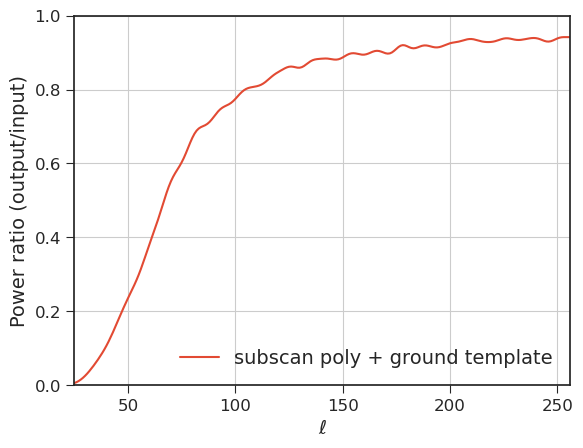

In [8]:
plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])

plt.plot(fl, label='subscan poly + ground template')
# plt.plot(fl_KS, label='KS purification')
# plt.plot(fl_pure, label='Matrix purification')

plt.legend(fontsize=14)
plt.xlim([25, 2*nside])
plt.ylim([0,1])
plt.grid()
plt.ylabel('Power ratio (output/input)', fontsize=14)
plt.xlabel('$\ell$', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plt.savefig('plots/ft.pdf', bbox_inches='tight')
plt.savefig('thesis_plots/ft.pdf', bbox_inches='tight')

In [58]:
hits = hp.read_map('obsmat_nside128/out/0/filterbin_hits.fits')

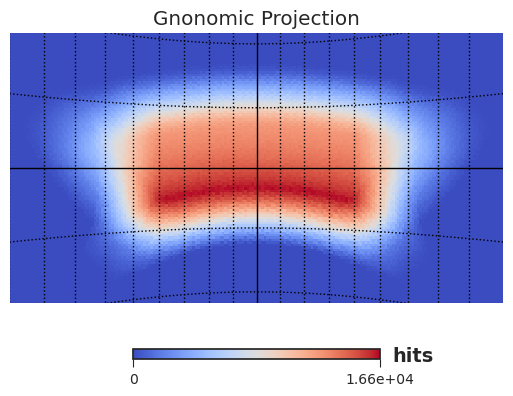

In [59]:
hp.gnomview(hits, cmap='coolwarm', rot=(40,-42), reso=25, ysize=110, unit='hits', title='Gnonomic Projection', notext=True)
hp.graticule()
plt.savefig('plots/hits.pdf', bbox_inches='tight')

In [10]:
ten = mylib.get_Nl([10,0,0], lmax)
twopfive = mylib.get_Nl([2.5,0,0], lmax)
one = mylib.get_Nl([1,0,0], lmax)

In [11]:
nmc = 128

cl_tteebb = np.empty((nmc, len(ells)))
cl_ttee = np.empty((nmc, len(ells)))

for i in tqdm(range(nmc)):
    np.random.seed(i)
    signal = hp.synfast(input_cls_noBB, nside, fwhm=fwhm, new=True)
    obs_m_unapo = (R_unapo @ signal.flatten()).reshape(3, npix)
    f = nmt.NmtField(mask_apo, mask*obs_m_unapo[1:], beam=bl*np.sqrt(fl_KS), purify_b=True)
    cl_ttee[i] = nmt.compute_full_master(f, f, b)[3]

    np.random.seed(i)
    signal = hp.synfast(input_cls_lcdm, nside, fwhm=fwhm, new=True)
    obs_m_unapo = (R_unapo @ signal.flatten()).reshape(3, npix)
    f = nmt.NmtField(mask_apo, mask*obs_m_unapo[1:], beam=bl*np.sqrt(fl_KS), purify_b=True)
    cl_tteebb[i] = nmt.compute_full_master(f, f, b)[3]
    
ttee_mean = c2db*np.mean(cl_ttee, axis=0)
ttee_std = c2db*np.std(cl_ttee, axis=0)

tteebb_mean = c2db*np.mean(cl_tteebb, axis=0)
tteebb_std =c2db*np.std(cl_tteebb, axis=0)

100%|█████████████████████████████████████████| 128/128 [06:30<00:00,  3.05s/it]


In [12]:
# # plt.figure(figsize=(7, 4))
# plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])

# plt.errorbar(ells, ttee_mean, yerr=ttee_std, fmt='o', alpha=0.75, label='$\Lambda$CDM (TTEE) input')
# plt.errorbar(ells, tteebb_mean, yerr=tteebb_std, fmt='o', alpha=0.75, label='$\Lambda$CDM (TTEEBB) input')
# plt.plot(l, c2d*input_cls_lcdm[2], label='Lensing BB')
# # plt.plot(c2d*ttee_mean, label=r'TTEEEE$\rightarrow$BB (leakage)')
# # plt.plot(c2d*ttbb_mean, label=r'TTBB$\rightarrow$BB')
# # plt.plot(c2d*tteebb_mean, label=r'TTEEBB$\rightarrow$BB')

# plt.loglog()
# plt.legend(fontsize=14)
# plt.xlim([20,2*nside])
# plt.ylim([1e-4,1e-1])
# plt.grid()
# plt.ylabel('$D_\ell$ [$\mu$K$^2$]', fontsize=18)
# plt.xlabel('$\ell$', fontsize=18)
# # plt.title('BB spectra for filtered $\Lambda$CDM maps', fontsize=20, pad=15)

# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

# plt.savefig('plots/leakage.pdf', bbox_inches='tight')

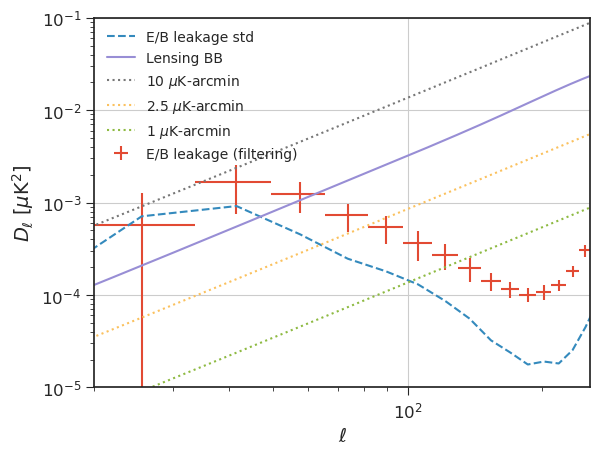

In [13]:
# plt.figure(figsize=(7, 4))
plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])

plt.errorbar(ells, ttee_mean, yerr=ttee_std, xerr=bin_size/2, linestyle='', alpha=1, label='E/B leakage (filtering)')
# plt.errorbar(ells, tteebb_mean, yerr=tteebb_std, fmt='o', alpha=0.75, label='$\Lambda$CDM (TTEEBB) input')
plt.plot(ells, ttee_std, ls='dashed', label='E/B leakage std')
plt.plot(l, c2d*input_cls_lcdm[2], label='Lensing BB')
plt.plot(l, c2d*ten, ls='dotted',label='10 $\mu$K-arcmin')
plt.plot(l, c2d*twopfive, ls='dotted',label='2.5 $\mu$K-arcmin')
plt.plot(l, c2d*one, ls='dotted',label='1 $\mu$K-arcmin')

plt.loglog()
plt.legend(fontsize=10)
plt.xlim([20,2*nside])
plt.ylim([1e-5,1e-1])
plt.grid()
plt.ylabel('$D_\ell$ [$\mu$K$^2$]', fontsize=14)
plt.xlabel('$\ell$', fontsize=14)
# plt.title('BB: Filtering leakage vs noise', fontsize=16, pad=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('plots/leakage_noise.pdf', bbox_inches='tight')

In [8]:
nmc = 128

cl = np.empty((nmc, len(ells)))
cl_KS = np.empty((nmc, len(ells)))

for i in tqdm(range(nmc)):
    np.random.seed(i)
    masked_signal = mask*hp.synfast(input_cls_lcdm, nside, fwhm=fwhm, new=True)
    f = nmt.NmtField(mask_apo, masked_signal[1:], beam=bl, purify_b=True)
    cl_KS[i] = nmt.compute_full_master(f, f, b)[3]

    np.random.seed(i)
    masked_signal = mask*hp.synfast(input_cls_lcdm, nside, fwhm=fwhm, new=True)
    f = nmt.NmtField(mask_apo, masked_signal[1:], beam=bl)
    cl[i] = nmt.compute_full_master(f, f, b)[3]
    
cl_mean = c2db*np.mean(cl, axis=0)
cl_std = c2db*np.std(cl, axis=0)

cl_KS_mean = c2db*np.mean(cl_KS, axis=0)
cl_KS_std =c2db*np.std(cl_KS, axis=0)

100%|█████████████████████████████████████████| 128/128 [03:05<00:00,  1.45s/it]


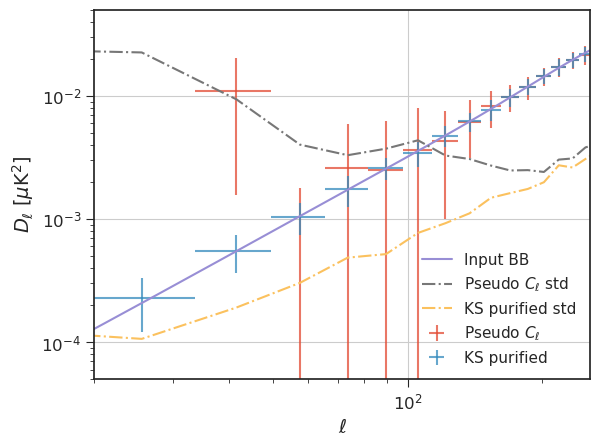

In [9]:
plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])

plt.errorbar(ells, cl_mean, yerr=cl_std, xerr=bin_size/2, linestyle='', alpha=0.75, label='Pseudo $C_\ell$')
plt.errorbar(ells, cl_KS_mean, yerr=cl_KS_std,xerr=bin_size/2, linestyle='', alpha=0.75, label='KS purified')
plt.plot(l, c2d*input_cls_lcdm[2], label='Input BB')

plt.plot(ells, cl_std, linestyle='dashdot', label='Pseudo $C_\ell$ std')
plt.plot(ells, cl_KS_std, linestyle='dashdot', label='KS purified std')

plt.loglog()
plt.legend(fontsize=11)
plt.xlim([20,2*nside])
plt.ylim([5e-5,5e-2])
plt.grid()
plt.ylabel('$D_\ell$ [$\mu$K$^2$]', fontsize=14)
plt.xlabel('$\ell$', fontsize=14)
# plt.title('BB spectra for masked $\Lambda$CDM maps (fsky=4.5%)', fontsize=16, pad=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('plots/KS.pdf', bbox_inches='tight')